In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch

In [ ]:
df = pd.read_csv('sample_data/data_modified.csv').drop(columns=['Unnamed: 0'])
df

,AT,V,AP,RH,PE
0,0.372521,0.291815,0.771591,0.638204,0.569536
1,0.662040,0.669039,0.671863,0.449330,0.319338
2,0.093484,0.249822,0.476862,0.892493,0.904636
3,0.539660,0.568683,0.429349,0.684718,0.347285
4,0.255241,0.216014,0.404355,0.952547,0.710464
...,...,...,...,...,...
9418,0.420397,0.432918,0.522643,0.877212,0.526755
9419,0.322380,0.245907,0.761693,0.552547,0.653775
9420,0.835977,0.871352,0.495669,0.146381,0.123311
9421,0.642210,0.784520,0.518931,0.493700,0.205033


In [ ]:
names = df.columns.values.tolist()[:-1]
n = len(names)
names

['AT', 'V', 'AP', 'RH']

In [ ]:
train_percent = 0.6
valid_percent = 0.3
test_percent = 0.1
l = len(df)
df_train = df[:int(train_percent*l)].reset_index(drop=True)
df_valid = df[int(train_percent*l):int((train_percent+valid_percent)*l)].reset_index(drop=True)
df_test = df[int((train_percent+valid_percent)*l):].reset_index(drop=True)

_data_train_x = df_train[['AT', 'V', 'AP', 'RH']].to_numpy()
_data_train_y = df_train[['PE']].to_numpy()

_data_validation_x = df_valid[['AT', 'V', 'AP', 'RH']].to_numpy()
_data_validation_y = df_valid[['PE']].to_numpy()

_data_test_x = df_test[['AT', 'V', 'AP', 'RH']].to_numpy()
_data_test_y = df_test[['PE']].to_numpy()

In [ ]:
X_train = torch.tensor(_data_train_x, dtype=torch.float32)
Y_train = torch.tensor(_data_train_y, dtype=torch.float32)

X_valid = torch.tensor(_data_validation_x, dtype=torch.float32)
Y_valid = torch.tensor(_data_validation_y, dtype=torch.float32)

X_test = torch.tensor(_data_test_x, dtype=torch.float32)
Y_test = torch.tensor(_data_test_y, dtype=torch.float32)

In [ ]:
firstLayerAmountOfNeurons = 10
secondLayerAmountOfNeurons = 10
thirdLayerAmountOfNeurons = 5
batch_size = len(df_train)
learning_rate = 0.1

In [ ]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.first_layer = nn.Linear(4, firstLayerAmountOfNeurons)
        self.second_layer = nn.Linear(firstLayerAmountOfNeurons, secondLayerAmountOfNeurons)
        self.third_layer = nn.Linear(secondLayerAmountOfNeurons, thirdLayerAmountOfNeurons)
        self.final_layer = nn.Linear(thirdLayerAmountOfNeurons, 1)

    def forward(self, X_batch):
        layer_out = F.tanh(self.first_layer(X_batch))
        layer_out = F.tanh(self.second_layer(layer_out))
        layer_out = F.tanh(self.third_layer(layer_out))
        return self.final_layer(layer_out)

In [ ]:
#@title SGD

torch.manual_seed(1) 
epochs = 1000

regressor = Regressor()
mse_loss = nn.MSELoss()
optimizer = torch.optim.SGD(params=regressor.parameters(), lr=learning_rate)

train_loss=[]
valid_loss=[]
test_loss=[]

for i in range(epochs):
  preds = regressor(X_train)
  loss = mse_loss(preds, Y_train) 

  preds1 = regressor(X_valid) 
  loss1 = mse_loss(preds1, Y_valid) 

  preds2 = regressor(X_test) 
  loss2 = mse_loss(preds2, Y_test) 

  optimizer.zero_grad() 
  loss.backward() 
  optimizer.step()
  train_loss.append(loss.data.numpy())
  valid_loss.append(loss1.data.numpy())
  test_loss.append(loss2.data.numpy())

learning_rate: 	0.1
Train loss: 	0.0035573614295572042
Test loss: 	0.0035692001692950726



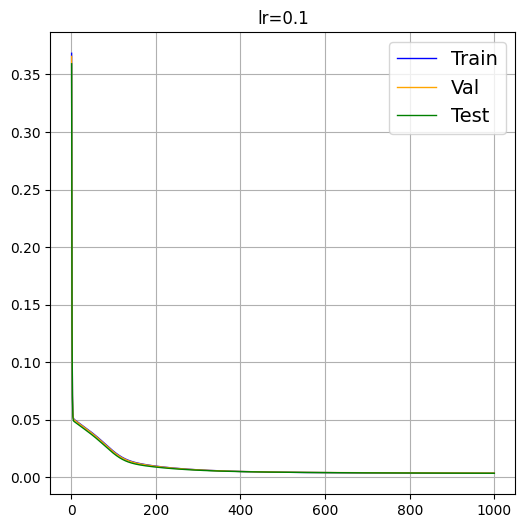

In [ ]:
#@title plot
fig8, ax8 = plt.subplots(1, 1)
fig8.set_size_inches((6, 6))

ax8.plot(np.linspace(1, epochs, epochs), train_loss,      label='Train',      linewidth=1, color="blue")
ax8.plot(np.linspace(1, epochs, epochs), valid_loss, label='Val',        linewidth=1, color="orange")
ax8.plot(np.linspace(1, epochs, epochs), test_loss,       label='Test',       linewidth=1, color="green")
ax8.set_title(f'lr={learning_rate}')
ax8.legend(fontsize=14)
ax8.grid()
  
print(f'learning_rate: \t{learning_rate}')
print(f'Train loss: \t{train_loss[-1]}')
print(f'Test loss: \t{test_loss[-1]}\n')

In [ ]:
#@title Флетчер Ривз
!pip install ncg_optimizer
import ncg_optimizer

torch.manual_seed(1) 
epochs = 1000

regressor = Regressor()
mse_loss = nn.MSELoss()
optimizer = ncg_optimizer.BASIC(regressor.parameters(), method = 'FR', lr=learning_rate)

train_loss=[]
valid_loss=[]
test_loss=[]

def closure():
    optimizer.zero_grad()
    mse_loss(regressor(X_train), Y_train).backward()
    return loss

for i in range(epochs):
  preds = regressor(X_train)
  loss = mse_loss(preds, Y_train) 

  preds1 = regressor(X_valid) 
  loss1 = mse_loss(preds1, Y_valid) 

  preds2 = regressor(X_test) 
  loss2 = mse_loss(preds2, Y_test) 

  optimizer.step(closure)

  train_loss.append(loss.data.numpy())
  valid_loss.append(loss1.data.numpy())
  test_loss.append(loss2.data.numpy())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


learning_rate: 	0.1
Train loss: 	0.059185292571783066
Test loss: 	0.05631871894001961



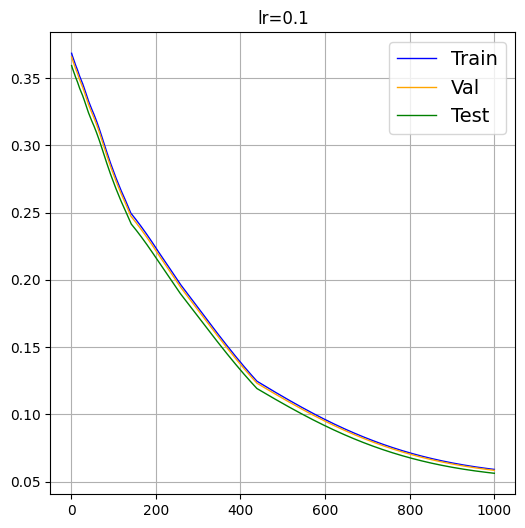

In [ ]:
#@title plot
fig8, ax8 = plt.subplots(1, 1)
fig8.set_size_inches((6, 6))

ax8.plot(np.linspace(1, epochs, epochs), train_loss,      label='Train',      linewidth=1, color="blue")
ax8.plot(np.linspace(1, epochs, epochs), valid_loss, label='Val',        linewidth=1, color="orange")
ax8.plot(np.linspace(1, epochs, epochs), test_loss,       label='Test',       linewidth=1, color="green")
ax8.set_title(f'lr={learning_rate}')
ax8.legend(fontsize=14)
ax8.grid()
  
print(f'learning_rate: \t{learning_rate}')
print(f'Train loss: \t{train_loss[-1]}')
print(f'Test loss: \t{test_loss[-1]}\n')

In [ ]:
#@title Поляк Рибьер
import ncg_optimizer

torch.manual_seed(1) 
epochs = 1000

regressor = Regressor()
mse_loss = nn.MSELoss()
optimizer = ncg_optimizer.BASIC(regressor.parameters(), method = 'PRP', lr=learning_rate)

train_loss=[]
valid_loss=[]
test_loss=[]

def closure():
    optimizer.zero_grad()
    mse_loss(regressor(X_train), Y_train).backward()
    return loss

for i in range(epochs):
  preds = regressor(X_train)
  loss = mse_loss(preds, Y_train) 

  preds1 = regressor(X_valid) 
  loss1 = mse_loss(preds1, Y_valid) 

  preds2 = regressor(X_test) 
  loss2 = mse_loss(preds2, Y_test) 

  optimizer.step(closure)

  train_loss.append(loss.data.numpy())
  valid_loss.append(loss1.data.numpy())
  test_loss.append(loss2.data.numpy())

learning_rate: 	0.1
Train loss: 	0.09036899358034134
Test loss: 	0.0858863964676857



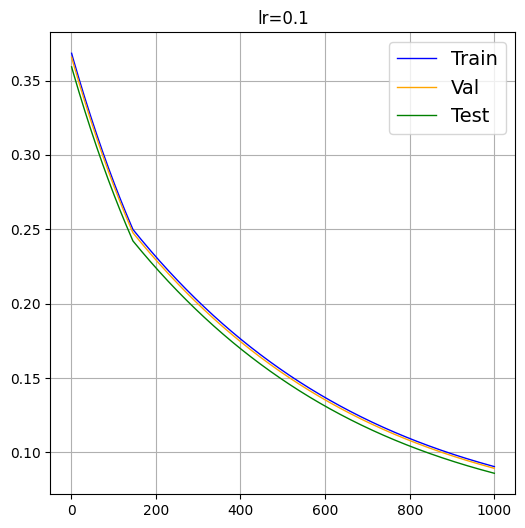

In [ ]:
#@title plot
fig8, ax8 = plt.subplots(1, 1)
fig8.set_size_inches((6, 6))

ax8.plot(np.linspace(1, epochs, epochs), train_loss,      label='Train',      linewidth=1, color="blue")
ax8.plot(np.linspace(1, epochs, epochs), valid_loss, label='Val',        linewidth=1, color="orange")
ax8.plot(np.linspace(1, epochs, epochs), test_loss,       label='Test',       linewidth=1, color="green")
ax8.set_title(f'lr={learning_rate}')
ax8.legend(fontsize=14)
ax8.grid()
  
print(f'learning_rate: \t{learning_rate}')
print(f'Train loss: \t{train_loss[-1]}')
print(f'Test loss: \t{test_loss[-1]}\n')

In [ ]:
#@title adagrad
torch.manual_seed(1) 
epochs = 100

regressor = Regressor()
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adagrad(params=regressor.parameters(), lr=learning_rate)

train_loss=[]
valid_loss=[]
test_loss=[]

for i in range(epochs):
  preds = regressor(X_train)
  loss = mse_loss(preds, Y_train) 

  preds1 = regressor(X_valid) 
  loss1 = mse_loss(preds1, Y_valid) 

  preds2 = regressor(X_test) 
  loss2 = mse_loss(preds2, Y_test) 

  optimizer.zero_grad() 
  loss.backward() 
  optimizer.step()
  train_loss.append(loss.data.numpy())
  valid_loss.append(loss1.data.numpy())
  test_loss.append(loss2.data.numpy())

learning_rate: 	0.1
Train loss: 	0.005193660967051983
Test loss: 	0.005092212464660406



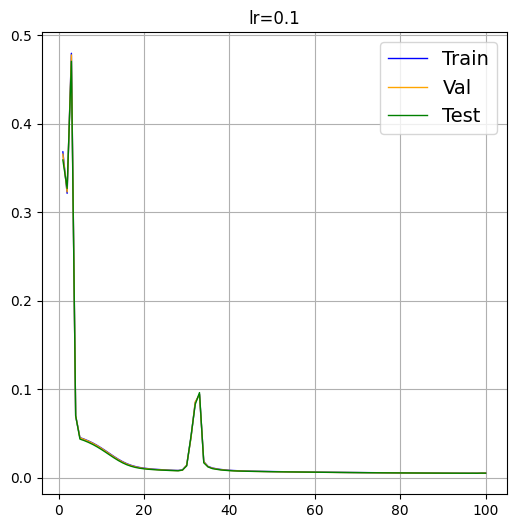

In [ ]:
#@title plot
fig8, ax8 = plt.subplots(1, 1)
fig8.set_size_inches((6, 6))

ax8.plot(np.linspace(1, epochs, epochs), train_loss,      label='Train',      linewidth=1, color="blue")
ax8.plot(np.linspace(1, epochs, epochs), valid_loss, label='Val',        linewidth=1, color="orange")
ax8.plot(np.linspace(1, epochs, epochs), test_loss,       label='Test',       linewidth=1, color="green")
ax8.set_title(f'lr={learning_rate}')
ax8.legend(fontsize=14)
ax8.grid()
  
print(f'learning_rate: \t{learning_rate}')
print(f'Train loss: \t{train_loss[-1]}')
print(f'Test loss: \t{test_loss[-1]}\n')

In [ ]:
#@title rmsprop
torch.manual_seed(1) 
epochs = 100

alphas = [0.0, 0.3, 0.6, 0.9]

train_loss=[[], [], [], []]
valid_loss=[[], [], [], []]
test_loss=[[], [], [], []]

for j, _alpha in enumerate(alphas):

  regressor = Regressor()
  mse_loss = nn.MSELoss()
  optimizer = torch.optim.RMSprop(params=regressor.parameters(), lr=learning_rate, alpha=_alpha)

  for i in range(epochs):
    preds = regressor(X_train)
    loss = mse_loss(preds, Y_train) 

    preds1 = regressor(X_valid) 
    loss1 = mse_loss(preds1, Y_valid) 

    preds2 = regressor(X_test) 
    loss2 = mse_loss(preds2, Y_test) 

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step()
    train_loss[j].append(loss.data.numpy())
    valid_loss[j].append(loss1.data.numpy())
    test_loss[j].append(loss2.data.numpy())

alpha: 	0.0
Train loss: 	0.08133216202259064
Test loss: 	0.07756466418504715

alpha: 	0.3
Train loss: 	0.05713868886232376
Test loss: 	0.058145612478256226

alpha: 	0.6
Train loss: 	0.035395387560129166
Test loss: 	0.03514876216650009

alpha: 	0.9
Train loss: 	0.11454389989376068
Test loss: 	0.1162455677986145



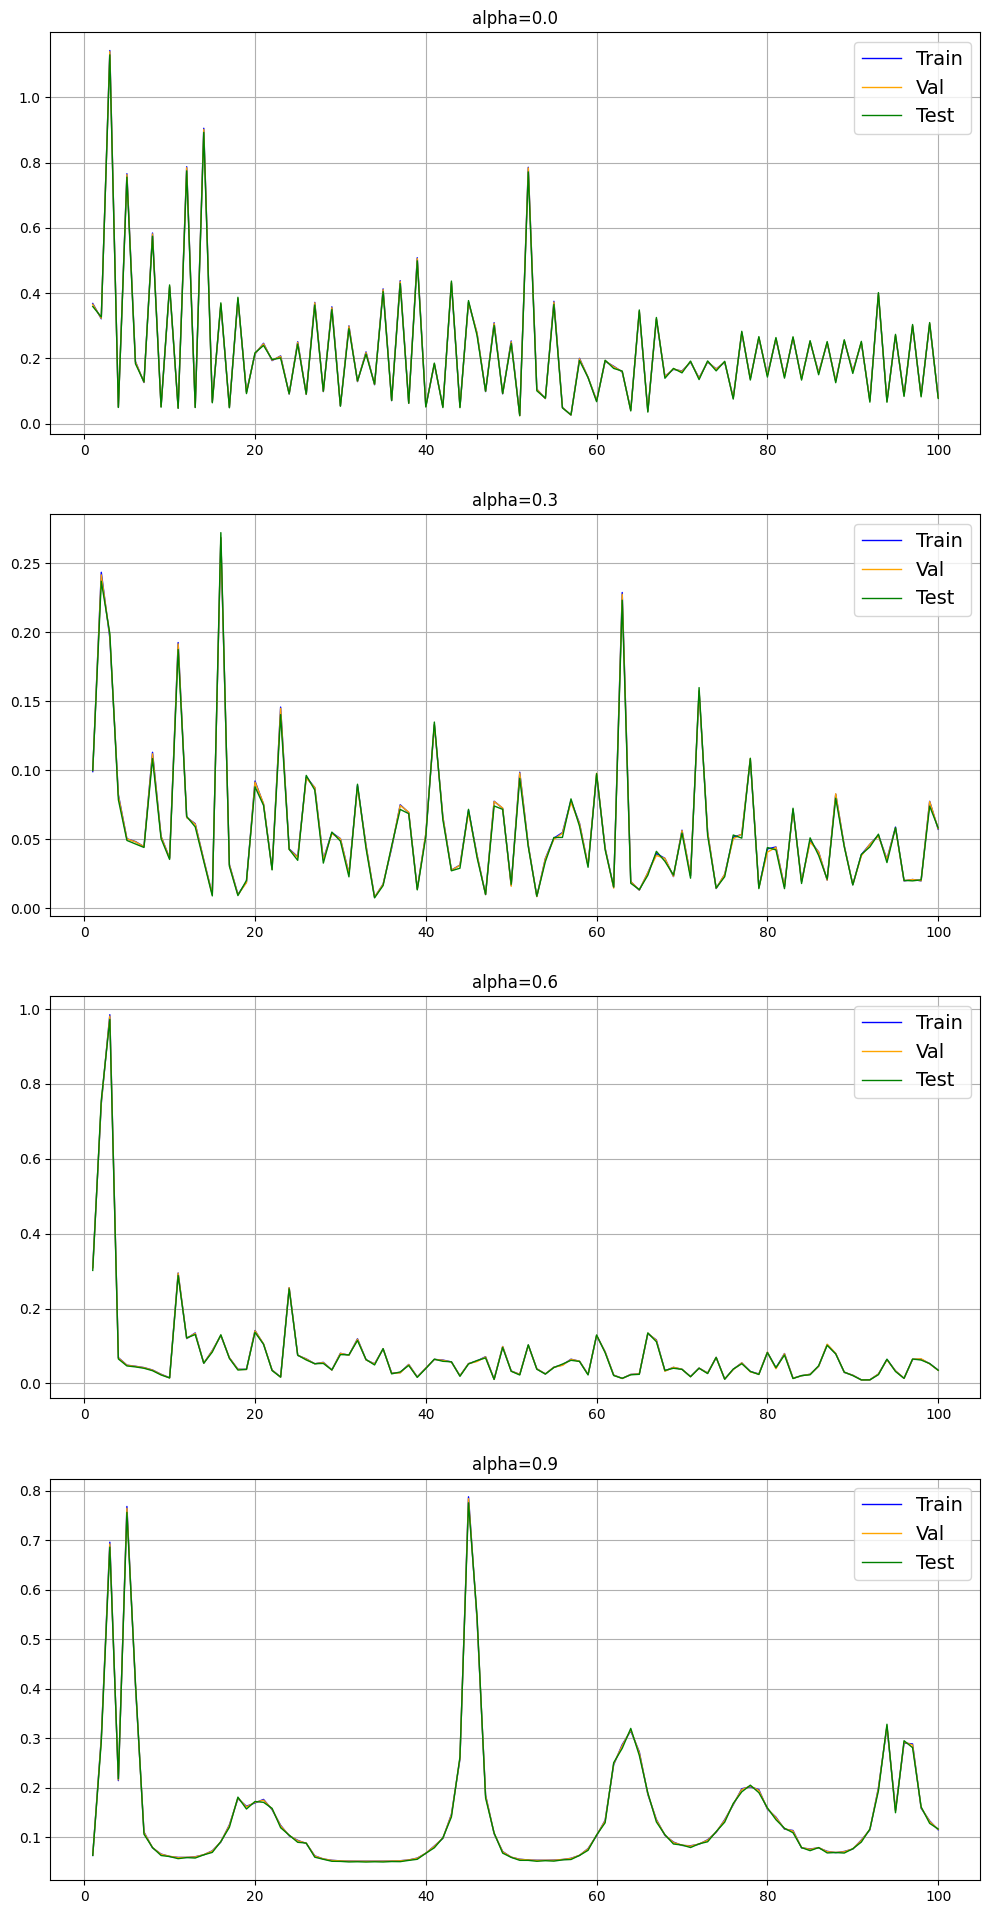

In [ ]:
#@title plot
fig8, ax8 = plt.subplots(4, 1)
fig8.set_size_inches((12, 24))

for i, _alpha in enumerate(alphas):
  ax8[i].plot(np.linspace(1, epochs, epochs), train_loss[i],      label='Train',      linewidth=1, color="blue")
  ax8[i].plot(np.linspace(1, epochs, epochs), valid_loss[i], label='Val',        linewidth=1, color="orange")
  ax8[i].plot(np.linspace(1, epochs, epochs), test_loss[i],       label='Test',       linewidth=1, color="green")
  ax8[i].set_title(f'alpha={_alpha}')
  ax8[i].legend(fontsize=14)
  ax8[i].grid()
    
  print(f'alpha: \t{_alpha}')
  print(f'Train loss: \t{train_loss[i][-1]}')
  print(f'Test loss: \t{test_loss[i][-1]}\n')

In [ ]:
#@title adadelta
torch.manual_seed(1) 
epochs = 100

alphas = [0.0, 0.3, 0.6, 0.9]

train_loss=[[], [], [], []]
valid_loss=[[], [], [], []]
test_loss=[[], [], [], []]

for j, _alpha in enumerate(alphas):

  regressor = Regressor()
  mse_loss = nn.MSELoss()
  optimizer = torch.optim.Adadelta(params=regressor.parameters(), lr=learning_rate, rho=_alpha)

  for i in range(epochs):
    preds = regressor(X_train)
    loss = mse_loss(preds, Y_train) 

    preds1 = regressor(X_valid) 
    loss1 = mse_loss(preds1, Y_valid) 

    preds2 = regressor(X_test) 
    loss2 = mse_loss(preds2, Y_test) 

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step()
    train_loss[j].append(loss.data.numpy())
    valid_loss[j].append(loss1.data.numpy())
    test_loss[j].append(loss2.data.numpy())

alpha: 	0.0
Train loss: 	0.046754829585552216
Test loss: 	0.044797398149967194

alpha: 	0.3
Train loss: 	0.042839474976062775
Test loss: 	0.041157446801662445

alpha: 	0.6
Train loss: 	0.03953566402196884
Test loss: 	0.03688521683216095

alpha: 	0.9
Train loss: 	0.045967936515808105
Test loss: 	0.04491821676492691



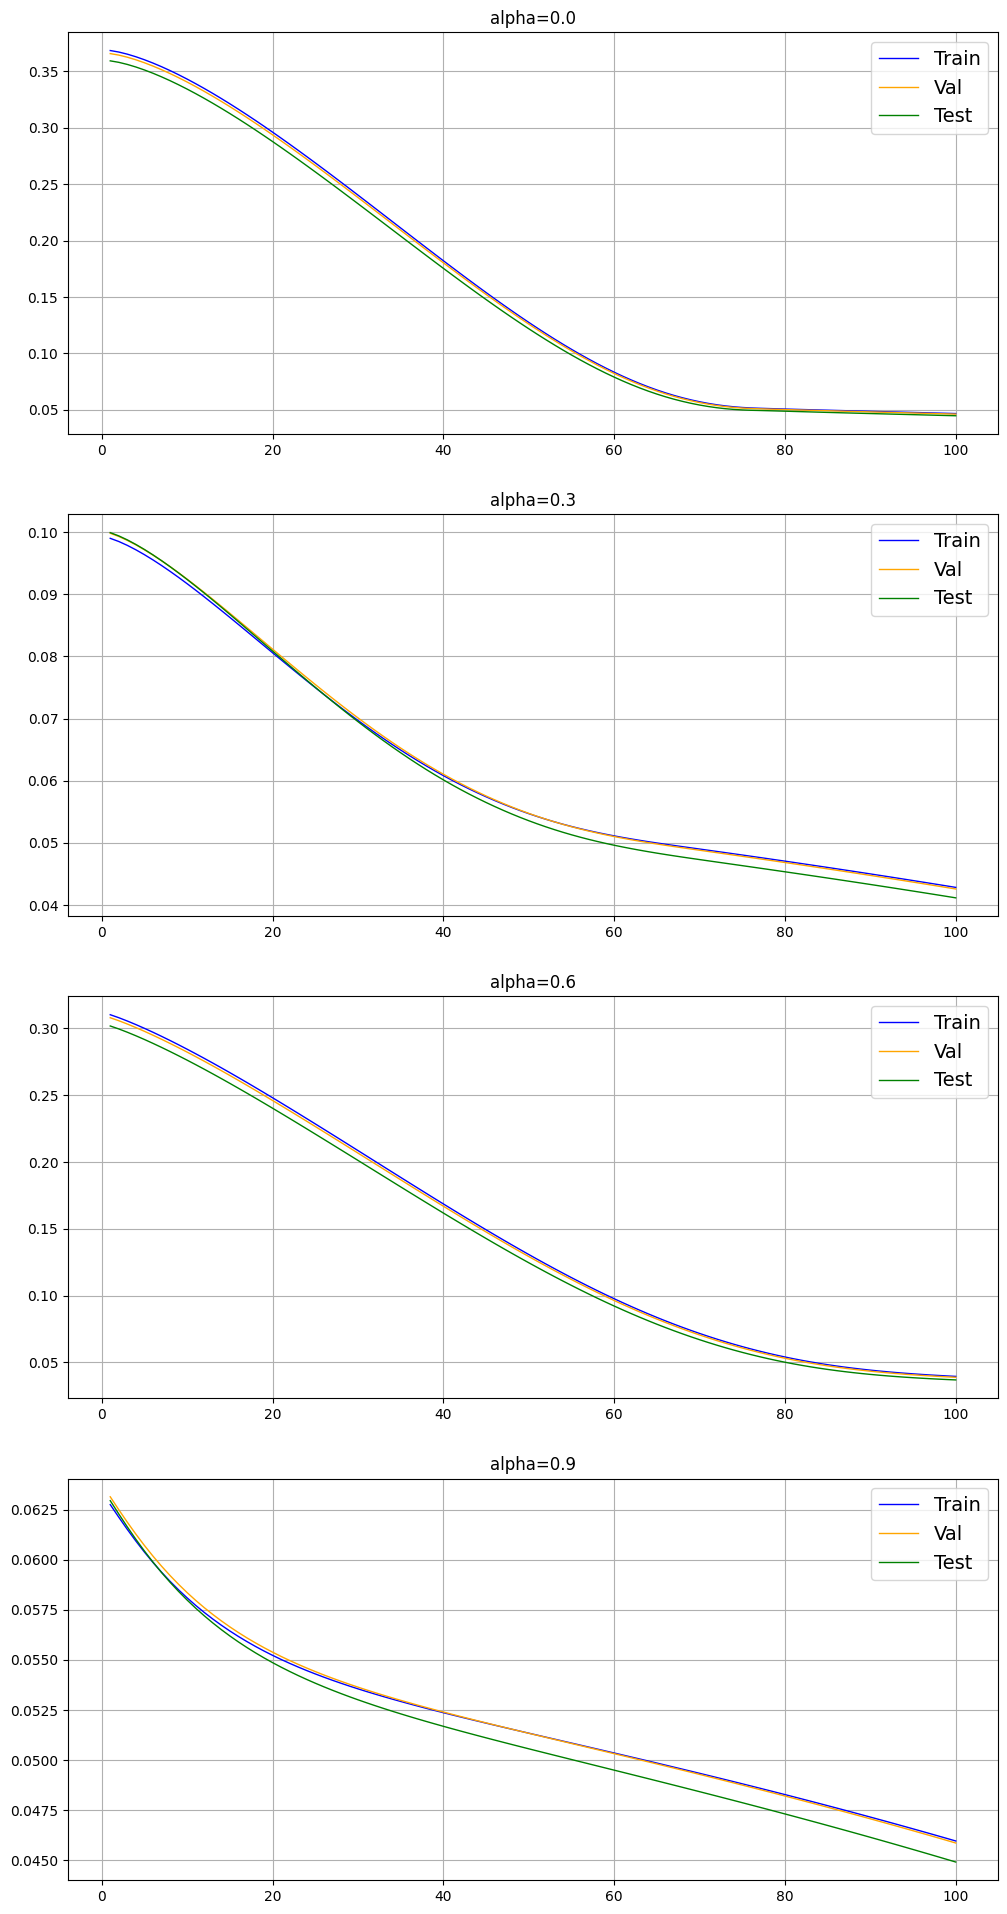

In [ ]:
#@title plot

fig8, ax8 = plt.subplots(4, 1)
fig8.set_size_inches((12, 24))

for i, _alpha in enumerate(alphas):
  ax8[i].plot(np.linspace(1, epochs, epochs), train_loss[i],      label='Train',      linewidth=1, color="blue")
  ax8[i].plot(np.linspace(1, epochs, epochs), valid_loss[i], label='Val',        linewidth=1, color="orange")
  ax8[i].plot(np.linspace(1, epochs, epochs), test_loss[i],       label='Test',       linewidth=1, color="green")
  ax8[i].set_title(f'alpha={_alpha}')
  ax8[i].legend(fontsize=14)
  ax8[i].grid()
    
  print(f'alpha: \t{_alpha}')
  print(f'Train loss: \t{train_loss[i][-1]}')
  print(f'Test loss: \t{test_loss[i][-1]}\n')

In [ ]:
#@title adam
torch.manual_seed(1) 
epochs = 100

alphas = [[0.0, 0.0], [0.1, 0.01], [0.3, 0.6], [0.6, 0.3], [0.5, 0.5], [0.9, 0.9]]

train_loss=[[], [], [], [], [], []]
valid_loss=[[], [], [], [], [], []]
test_loss=[[], [], [], [], [], []]

weights = [[[], [], []], [[], [], []], [[], [], []], [[], [], []], [[], [], []], [[], [], []]]

for j, _alpha in enumerate(alphas):

  regressor = Regressor()
  mse_loss = nn.MSELoss()
  optimizer = torch.optim.Adam(params=regressor.parameters(), lr=learning_rate, betas=_alpha)

  for i in range(epochs):
    preds = regressor(X_train)
    loss = mse_loss(preds, Y_train) 

    preds1 = regressor(X_valid) 
    loss1 = mse_loss(preds1, Y_valid) 

    preds2 = regressor(X_test) 
    loss2 = mse_loss(preds2, Y_test) 

    weights[j][0].append(regressor.first_layer.weight[0,0].item())
    weights[j][1].append(regressor.second_layer.weight[4,4].item())
    weights[j][2].append(regressor.final_layer.weight[0,0].item())

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step()
    train_loss[j].append(loss.data.numpy())
    valid_loss[j].append(loss1.data.numpy())
    test_loss[j].append(loss2.data.numpy())

alpha: 	[0.0, 0.0]
Train loss: 	0.08133216202259064
Test loss: 	0.07756466418504715

alpha: 	[0.1, 0.01]
Train loss: 	0.03055914118885994
Test loss: 	0.028602920472621918

alpha: 	[0.3, 0.6]
Train loss: 	0.058663077652454376
Test loss: 	0.05974709987640381

alpha: 	[0.6, 0.3]
Train loss: 	0.01285129226744175
Test loss: 	0.01334136351943016

alpha: 	[0.5, 0.5]
Train loss: 	0.018883584067225456
Test loss: 	0.019361961632966995

alpha: 	[0.9, 0.9]
Train loss: 	0.005199769511818886
Test loss: 	0.004813702777028084



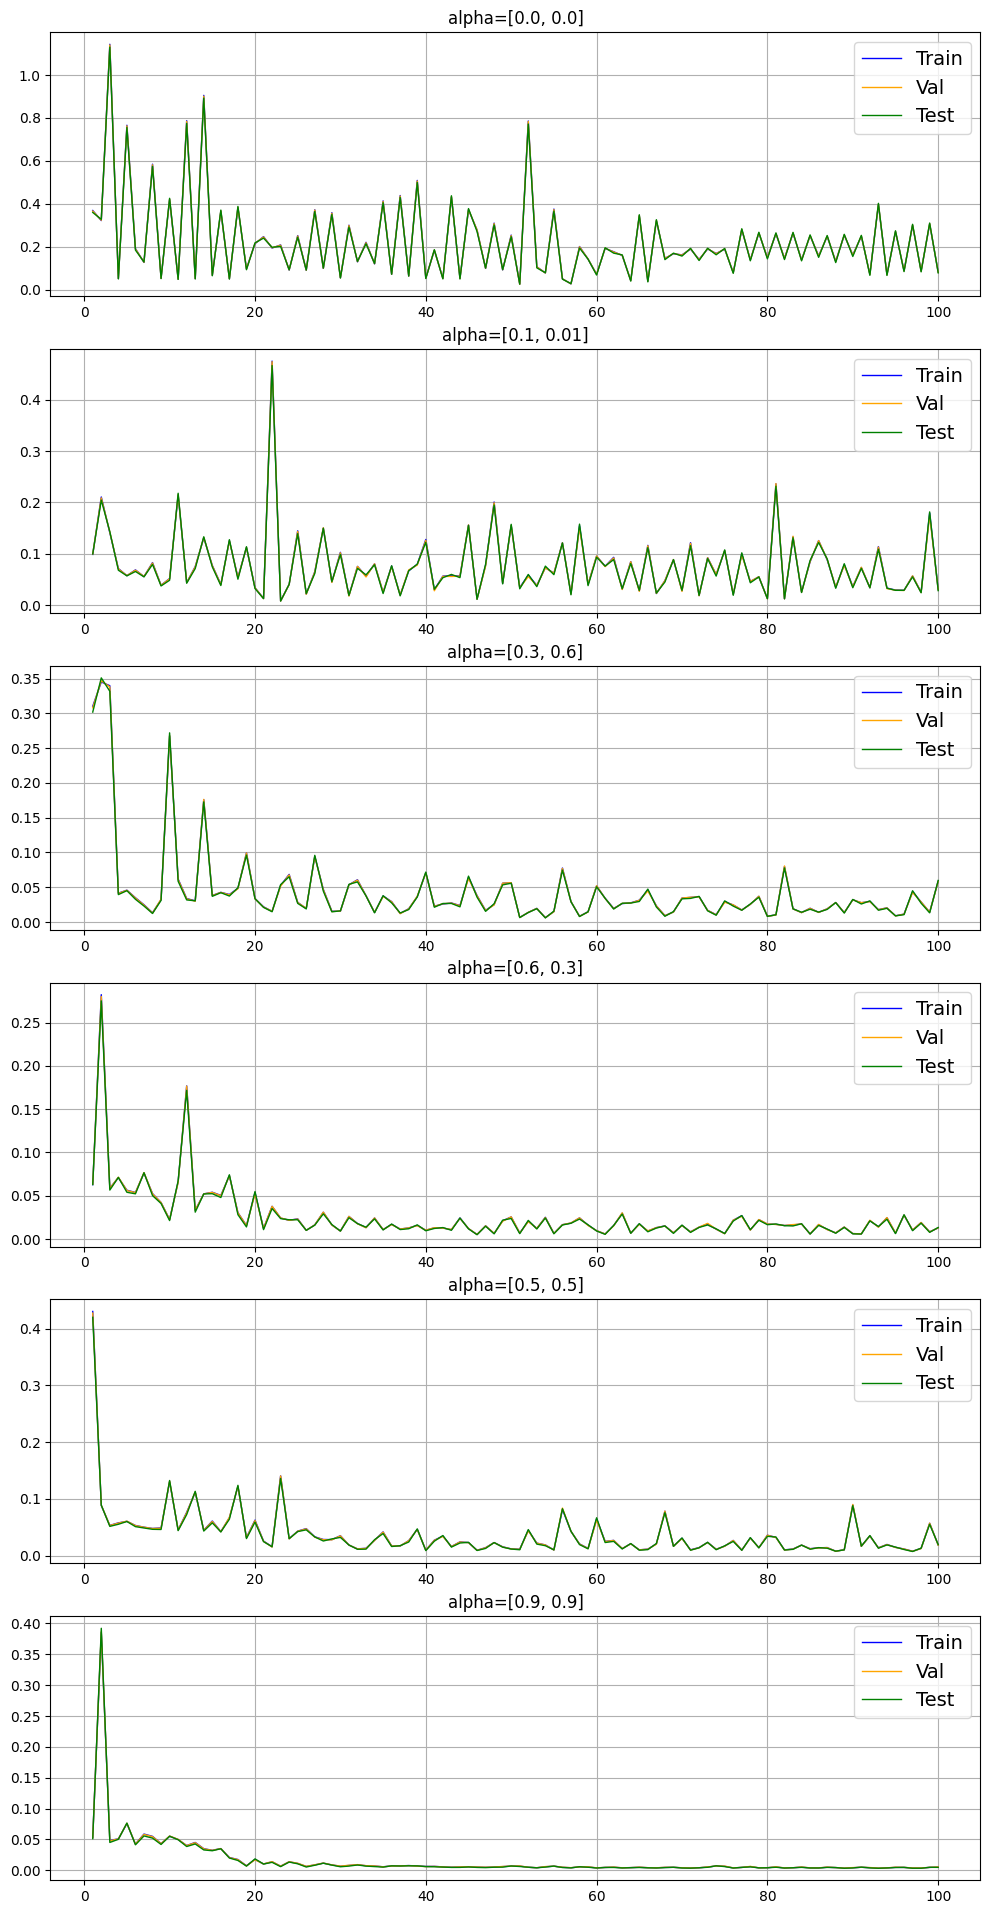

In [ ]:
#@title plot
fig8, ax8 = plt.subplots(6, 1)
fig8.set_size_inches((12, 24))

for i, _alpha in enumerate(alphas):
  ax8[i].plot(np.linspace(1, epochs, epochs), train_loss[i],      label='Train',      linewidth=1, color="blue")
  ax8[i].plot(np.linspace(1, epochs, epochs), valid_loss[i], label='Val',        linewidth=1, color="orange")
  ax8[i].plot(np.linspace(1, epochs, epochs), test_loss[i],       label='Test',       linewidth=1, color="green")
  ax8[i].set_title(f'alpha={_alpha}')
  ax8[i].legend(fontsize=14)
  ax8[i].grid()
    
  print(f'alpha: \t{_alpha}')
  print(f'Train loss: \t{train_loss[i][-1]}')
  print(f'Test loss: \t{test_loss[i][-1]}\n')

alpha: 	[0.0, 0.0]
Train loss: 	0.08133216202259064
Test loss: 	0.07756466418504715

alpha: 	[0.1, 0.01]
Train loss: 	0.03055914118885994
Test loss: 	0.028602920472621918

alpha: 	[0.3, 0.6]
Train loss: 	0.058663077652454376
Test loss: 	0.05974709987640381

alpha: 	[0.6, 0.3]
Train loss: 	0.01285129226744175
Test loss: 	0.01334136351943016

alpha: 	[0.5, 0.5]
Train loss: 	0.018883584067225456
Test loss: 	0.019361961632966995

alpha: 	[0.9, 0.9]
Train loss: 	0.005199769511818886
Test loss: 	0.004813702777028084



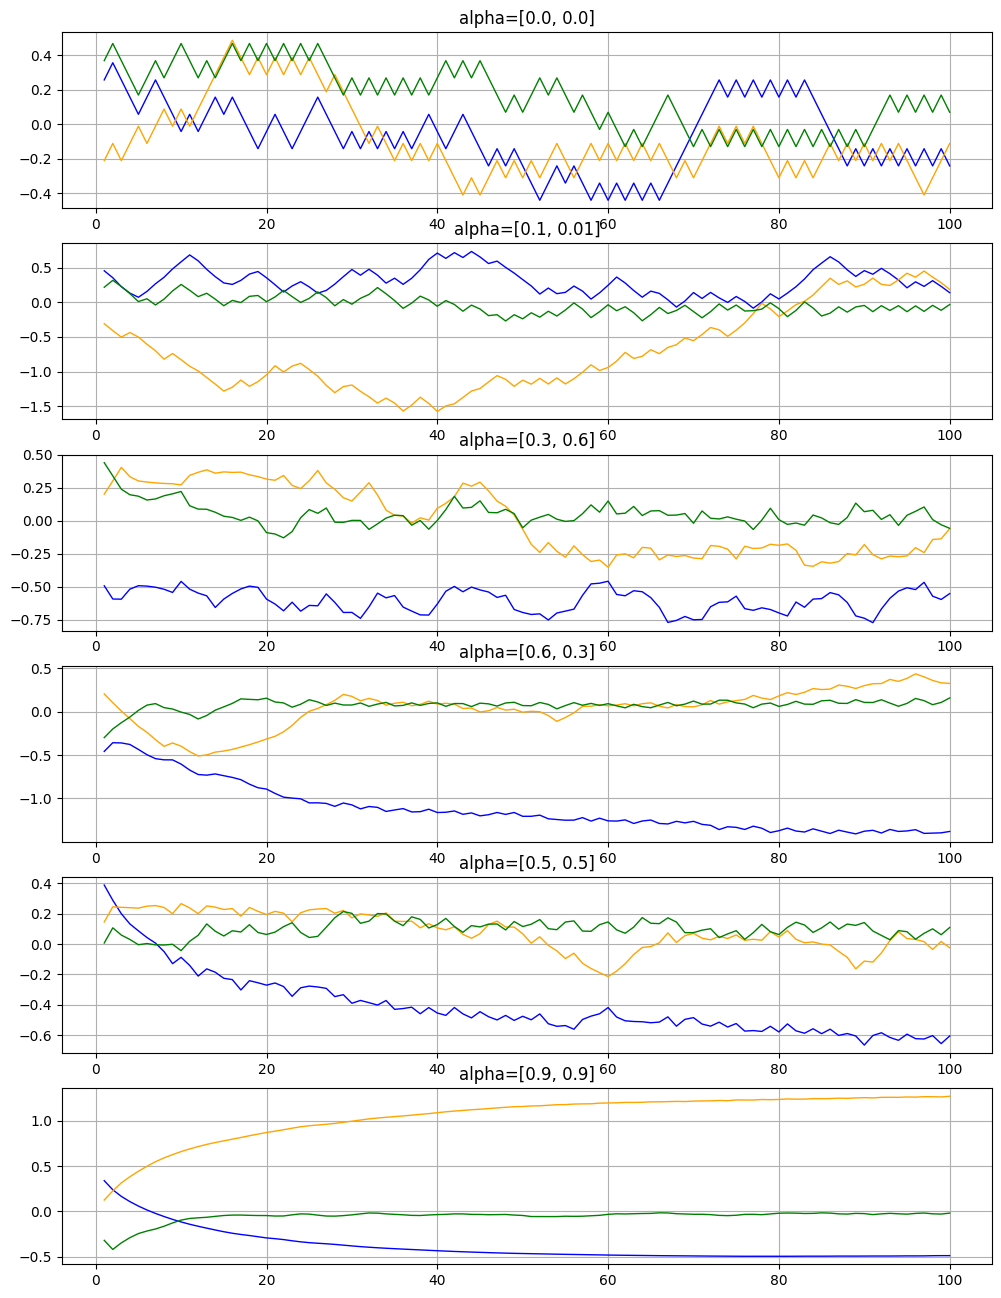

In [ ]:
#@title plot weights

fig8, ax8 = plt.subplots(6, 1)
fig8.set_size_inches((12, 16))


for i, _alpha in enumerate(alphas):
  ax8[i].plot(np.linspace(1, epochs, epochs), weights[i][0],     linewidth=1, color="blue")
  ax8[i].plot(np.linspace(1, epochs, epochs), weights[i][1],      linewidth=1, color="orange")
  ax8[i].plot(np.linspace(1, epochs, epochs), weights[i][2],       linewidth=1, color="green")
  ax8[i].set_title(f'alpha={_alpha}')
  ax8[i].grid()
    
  print(f'alpha: \t{_alpha}')
  print(f'Train loss: \t{train_loss[i][-1]}')
  print(f'Test loss: \t{test_loss[i][-1]}\n')

In [ ]:
#@title Rprop
torch.manual_seed(1) 
epochs = 100

train_loss=[[], [], [], [], [], []]
valid_loss=[[], [], [], [], [], []]
test_loss=[[], [], [], [], [], []]

alphas = [1]
weights = [[[], [], []]]
for j, _alpha in enumerate(alphas):

  regressor = Regressor()
  mse_loss = nn.MSELoss()
  optimizer = torch.optim.Rprop(params=regressor.parameters(), lr=learning_rate)

  for i in range(epochs):
    preds = regressor(X_train)
    loss = mse_loss(preds, Y_train) 

    preds1 = regressor(X_valid) 
    loss1 = mse_loss(preds1, Y_valid) 

    preds2 = regressor(X_test) 
    loss2 = mse_loss(preds2, Y_test) 

    weights[j][0].append(regressor.first_layer.weight[0,0].item())
    weights[j][1].append(regressor.second_layer.weight[4,4].item())
    weights[j][2].append(regressor.final_layer.weight[0,0].item())

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step()
    train_loss[j].append(loss.data.numpy())
    valid_loss[j].append(loss1.data.numpy())
    test_loss[j].append(loss2.data.numpy())

alpha: 	1
Train loss: 	0.0032093555200845003
Test loss: 	0.0031190430745482445



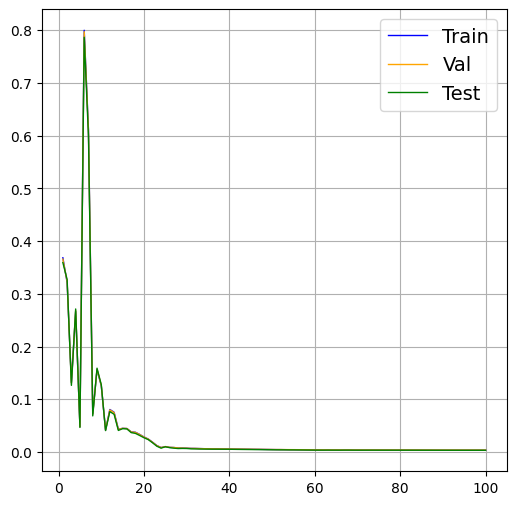

In [ ]:
#@title plot
fig8, ax8 = plt.subplots(1, 1)
fig8.set_size_inches((6, 6))

for i, _alpha in enumerate(alphas):
  ax8.plot(np.linspace(1, epochs, epochs), train_loss[i],      label='Train',      linewidth=1, color="blue")
  ax8.plot(np.linspace(1, epochs, epochs), valid_loss[i], label='Val',        linewidth=1, color="orange")
  ax8.plot(np.linspace(1, epochs, epochs), test_loss[i],       label='Test',       linewidth=1, color="green")
  #ax8.set_title(f'alpha={_alpha}')
  ax8.legend(fontsize=14)
  ax8.grid()
    
  print(f'alpha: \t{_alpha}')
  print(f'Train loss: \t{train_loss[i][-1]}')
  print(f'Test loss: \t{test_loss[i][-1]}\n')

[[0.2576315999031067, 0.3576315939426422, 0.3576315939426422, 0.40763160586357117, 0.40763160586357117, 0.3826315999031067, 0.3826315999031067, 0.39513158798217773, 0.39513158798217773, 0.40138158202171326, 0.4088815748691559, 0.417881578207016, 0.417881578207016, 0.41338157653808594, 0.4079815745353699, 0.4079815745353699, 0.4106815755367279, 0.4106815755367279, 0.4093315899372101, 0.40771159529685974, 0.40771159529685974, 0.4085215926170349, 0.4094935953617096, 0.4106599986553192, 0.4106599986553192, 0.411243200302124, 0.4119430482387543, 0.4119430482387543, 0.41159313917160034, 0.41159313917160034, 0.4117681086063385, 0.4119780659675598, 0.4119780659675598, 0.4120830297470093, 0.41220900416374207, 0.41236016154289246, 0.41254156827926636, 0.4127592444419861, 0.41302046179771423, 0.413333922624588, 0.4137100577354431, 0.41416144371032715, 0.4147031009197235, 0.41535308957099915, 0.4161330759525299, 0.41706904768943787, 0.41706904768943787, 0.41753703355789185, 0.4180986285209656, 0.4

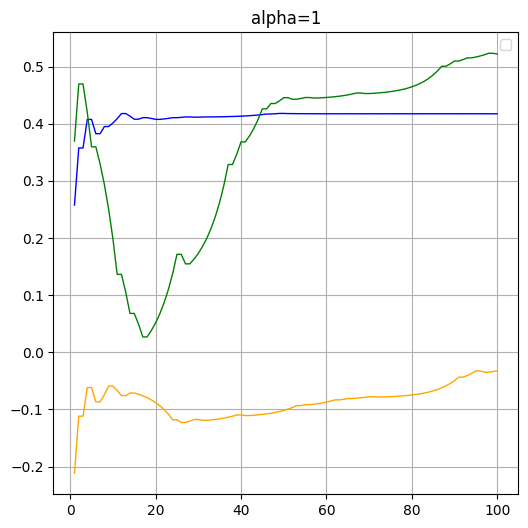

In [ ]:
#@title plot weights
fig8, ax8 = plt.subplots(1, 1)
fig8.set_size_inches((6, 6))

print(weights[0])

for i, _alpha in enumerate(alphas):
  ax8.plot(np.linspace(1, epochs, epochs), weights[i][0],     linewidth=1, color="blue")
  ax8.plot(np.linspace(1, epochs, epochs), weights[i][1],      linewidth=1, color="orange")
  ax8.plot(np.linspace(1, epochs, epochs), weights[i][2],       linewidth=1, color="green")
  ax8.set_title(f'alpha={_alpha}')
  ax8.legend()
  ax8.grid()
    
  print(f'alpha: \t{_alpha}')
  print(f'Train loss: \t{train_loss[i][-1]}')
  print(f'Test loss: \t{test_loss[i][-1]}\n')

In [ ]:
#@title Левенберг

torch.manual_seed(1) 
epochs = 100

train_loss=[[], [], [], [], [], []]
valid_loss=[[], [], [], [], [], []]
test_loss=[[], [], [], [], [], []]

alphas = [1]
weights = [[[], [], []]]
for j, _alpha in enumerate(alphas):

  regressor = Regressor()
  mse_loss = nn.MSELoss()
  #optimizer = torch.optim.Adam(params=regressor.parameters(), lr=0.23)

  for i in range(epochs):
    preds = regressor(X_train)
    loss = mse_loss(preds, Y_train) 

    preds1 = regressor(X_valid) 
    loss1 = mse_loss(preds1, Y_valid) 

    preds2 = regressor(X_test) 
    loss2 = mse_loss(preds2, Y_test) 

    weights[j][0].append(regressor.first_layer.weight[0,0].item())
    weights[j][1].append(regressor.second_layer.weight[4,4].item())
    weights[j][2].append(regressor.final_layer.weight[0,0].item())

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step()
    train_loss[j].append(loss.data.numpy())
    valid_loss[j].append(loss1.data.numpy())
    test_loss[j].append(loss2.data.numpy())

alpha: 	1
Train loss: 	0.3683542311191559
Test loss: 	0.3592214286327362



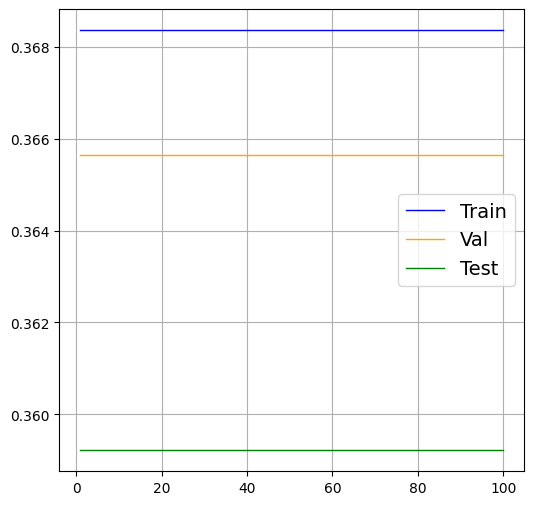

In [ ]:
#@title plot
fig8, ax8 = plt.subplots(1, 1)
fig8.set_size_inches((6, 6))

for i, _alpha in enumerate(alphas):
  ax8.plot(np.linspace(1, epochs, epochs), train_loss[i],      label='Train',      linewidth=1, color="blue")
  ax8.plot(np.linspace(1, epochs, epochs), valid_loss[i], label='Val',        linewidth=1, color="orange")
  ax8.plot(np.linspace(1, epochs, epochs), test_loss[i],       label='Test',       linewidth=1, color="green")
  #ax8.set_title(f'alpha={_alpha}')
  ax8.legend(fontsize=14)
  ax8.grid()
    
  print(f'alpha: \t{_alpha}')
  print(f'Train loss: \t{train_loss[i][-1]}')
  print(f'Test loss: \t{test_loss[i][-1]}\n')

In [ ]:
#@title lbfgs
torch.manual_seed(1) 
epochs = 100

regressor = Regressor()
mse_loss = nn.MSELoss()
optimizer = torch.optim.LBFGS(regressor.parameters(), lr=learning_rate)

train_loss=[]
valid_loss=[]
test_loss=[]

def closure():
    optimizer.zero_grad()
    mse_loss(regressor(X_train), Y_train).backward()
    return loss

for i in range(epochs):
  preds = regressor(X_train)
  loss = mse_loss(preds, Y_train) 

  preds1 = regressor(X_valid) 
  loss1 = mse_loss(preds1, Y_valid) 

  preds2 = regressor(X_test) 
  loss2 = mse_loss(preds2, Y_test) 

  optimizer.step(closure)

  train_loss.append(loss.data.numpy())
  valid_loss.append(loss1.data.numpy())
  test_loss.append(loss2.data.numpy())

alpha: 	1
Train loss: 	0.0032606623135507107
Test loss: 	0.0032721899915486574



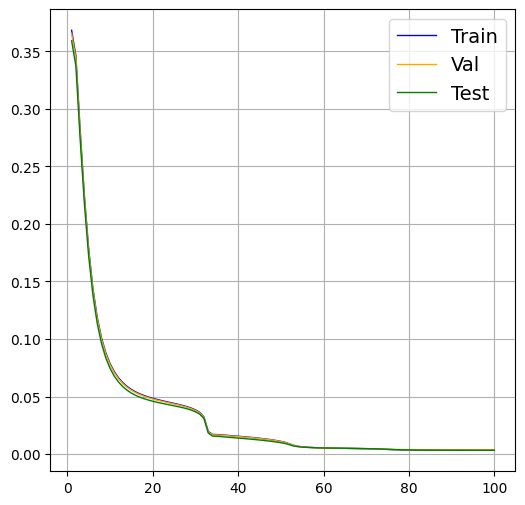

In [ ]:
#@title plot
fig8, ax8 = plt.subplots(1, 1)
fig8.set_size_inches((6, 6))

for i, _alpha in enumerate(alphas):
  ax8.plot(np.linspace(1, epochs, epochs), train_loss,      label='Train',      linewidth=1, color="blue")
  ax8.plot(np.linspace(1, epochs, epochs), valid_loss, label='Val',        linewidth=1, color="orange")
  ax8.plot(np.linspace(1, epochs, epochs), test_loss,       label='Test',       linewidth=1, color="green")
  #ax8.set_title(f'alpha={_alpha}')
  ax8.legend(fontsize=14)
  ax8.grid()
    
  print(f'alpha: \t{_alpha}')
  print(f'Train loss: \t{train_loss[-1]}')
  print(f'Test loss: \t{test_loss[-1]}\n')